<a href="https://colab.research.google.com/github/rayaneghilene/BERT_classification/blob/main/Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of the performance BERT models on a classification task

Modify the following variables based on your data
* **DATAPATH**: is the path to your dataset in your environment

In [1]:
DATAPATH = '/content/Multitarget-CONAN (2).csv'

## Data  

In [12]:
!pip install nltk
!pip install keras
!pip install tensorflow
!pip install tensorflow_hub
!pip install transformers

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss


 # Load your dataset from the DataFrame
df = pd.read_csv(DATAPATH)

max_features = 10000
sequence_length = 250

In [13]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(df['HATE_SPEECH'])
label_mapping = {subtype: label for label, subtype in enumerate(df['TARGET'].unique())}
num_classes = len(label_mapping)
len(label_mapping)


batch_size = 16
def vectorize_text(text, label):
    return vectorize_layer(text), label

df['label'] = df['TARGET'].map(label_mapping)

train_df, remaining_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(remaining_df, test_size=0.5, random_state=42)

# Training dataset
train_texts = train_df['HATE_SPEECH'].tolist()
train_labels = train_df['label'].tolist()

# validation dataset
val_texts = val_df['HATE_SPEECH'].tolist()
val_labels = val_df['label'].tolist()

# Testing dataset
test_texts = test_df['HATE_SPEECH'].tolist()
test_labels = test_df['label'].tolist()

## I - BERT

In [14]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, RandomSampler


# Hyperparameters
batch_size = 16
epochs = 1
learning_rate = 2e-5
num_labels = num_classes  # Assuming your labels are integer-encoded

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Tokenization and DataLoader
# Training
train_inputs = tokenizer(train_texts, padding=True, truncation=True, return_tensors="pt")
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], torch.tensor(train_labels))
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)

# validation
val_inputs = tokenizer(val_texts, padding=True, truncation=True, return_tensors="pt")
val_dataset = TensorDataset(val_inputs['input_ids'], val_inputs['attention_mask'], torch.tensor(val_labels))
val_dataloader = DataLoader(val_dataset, sampler=RandomSampler(val_dataset), batch_size=batch_size)

# testing
test_inputs = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt")
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], torch.tensor(test_labels))
test_dataloader = DataLoader(test_dataset, sampler=RandomSampler(test_dataset), batch_size=batch_size)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

def validate_model(model, dataloader):
    """
    Validation loop to evaluate the model on the validation set.
    """
    model.eval()  # Set the model to evaluation mode
    val_losses = []
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to compute gradients during validation
        for batch in dataloader:
            input_ids, attention_mask, label = batch

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=label)
            loss = outputs.loss
            logits = outputs.logits

            val_losses.append(loss.item())

            # Compute predictions and true labels
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = label.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    # Compute validation metrics
    avg_val_loss = sum(val_losses) / len(val_losses)
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)

    return avg_val_loss, accuracy, report



# Training Loop
train_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    print('-' * 10)
    batch_count = 0
    for batch in train_dataloader:
        batch_count += 1
        print(f"Batch {batch_count}/{len(test_dataloader)}")  # Print current batch count out of total batches
        model.train()
        optimizer.zero_grad()
        input_ids, attention_mask, label = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=label)
        loss = outputs.loss
        print(f"Loss: {loss.item():.4f}")
        train_losses.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        print('-' * 50)
# Validation loop
val_loss, val_accuracy, val_report = validate_model(model, val_dataloader)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Validation Report:")
print(val_report)
print('-' * 50)

# Save the fine-tuned model
model.save_pretrained('fine_tuned_bert_model')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1
----------
Batch 1/251
Loss: 2.1842
--------------------------------------------------
Batch 2/251
Loss: 2.0376
--------------------------------------------------
Batch 3/251
Loss: 2.0199
--------------------------------------------------
Batch 4/251
Loss: 2.0346
--------------------------------------------------
Batch 5/251
Loss: 1.9493
--------------------------------------------------
Batch 6/251
Loss: 2.0182
--------------------------------------------------
Batch 7/251
Loss: 1.9120
--------------------------------------------------
Batch 8/251
Loss: 1.8419
--------------------------------------------------
Batch 9/251
Loss: 1.9878
--------------------------------------------------
Batch 10/251
Loss: 1.9292
--------------------------------------------------
Batch 11/251
Loss: 1.8645
--------------------------------------------------
Batch 12/251
Loss: 1.9465
--------------------------------------------------
Batch 13/251
Loss: 2.0673
--------------------------------------

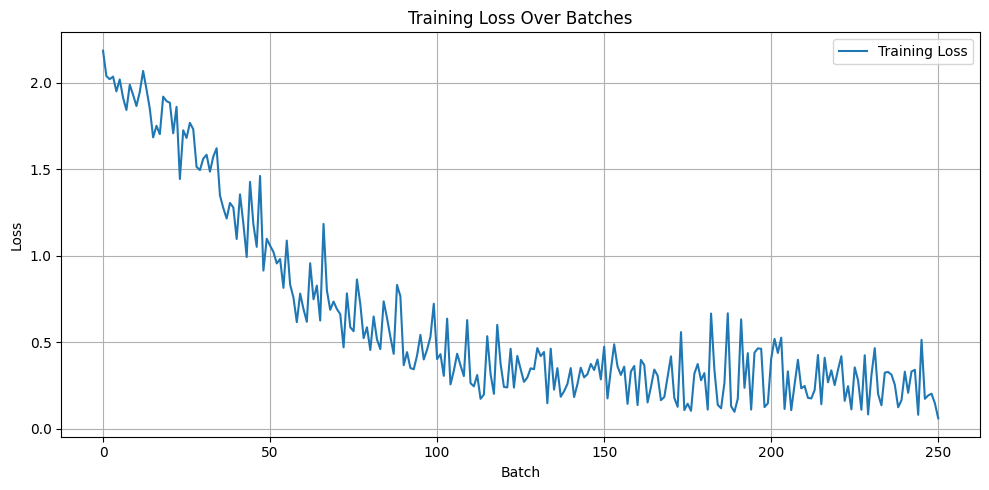

In [15]:
# Plot the training losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Batches')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Test on a custom prompt

In [16]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the fine-tuned model
model = BertForSequenceClassification.from_pretrained('/content/fine_tuned_bert_model')

# Tokenize the test data
test_texts = ["jews", "muslims", "disabled"]
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
inputs = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt")

# Perform inference
outputs = model(**inputs)
predictions = torch.argmax(outputs.logits, dim=1)

# Print the predictions
print(predictions)

print(label_mapping)

tensor([1, 6, 7])
{'other': 0, 'JEWS': 1, 'MIGRANTS': 2, 'WOMEN': 3, 'POC': 4, 'LGBT+': 5, 'MUSLIMS': 6, 'DISABLED': 7}
